<a href="https://colab.research.google.com/github/sumitmandloism/US500-Transformer-Model-base/blob/main/US500_transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# necessary libraries
!pip install tensorflow==2.14.0
!pip install yfinance
!pip install vectorbt
!pip install pandas_ta
!pip install matplotlib


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ES Futures data from Yahoo Finance
ticker = "ES=F"  #S&P 500 Futures
es_data = yf.download(tickers = 'ES=F', start = '2024-03-01',end = '2024-08-31')

# Checking for missing data and drop missing rows
es_data.dropna(inplace=True)

# Calculating returns
es_data['Return'] = es_data['Close'].pct_change().shift(-1)

# rows with NaN values
es_data.dropna(inplace=True)

# OHLCV features for the model
features = es_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
returns = es_data['Return'].values

#OHLCV features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#sliding windows for time series (50 timesteps window size)
def sliding_windows(data, labels, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(labels[i + window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = sliding_windows(features_scaled, returns, window_size)

# data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train.shape, X_val.shape, X_test.shape


[*********************100%***********************]  1 of 1 completed


((60, 50, 5), (8, 50, 5), (8, 50, 5))

# New section

In [3]:
import tensorflow as tf

# custom Transformer block layer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"),
             tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Transformer-based model for time series prediction
def transformer_model(seq_len, num_features, embed_dim, num_heads, ff_dim, num_blocks):
    inputs = tf.keras.Input(shape=(seq_len, num_features))
    x = tf.keras.layers.Dense(embed_dim)(inputs)  # Linear transformation

    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1)(x)  # Predict the next return

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters for the model
seq_len = 50
num_features = 5
embed_dim = 64
num_heads = 8
ff_dim = 128
num_blocks = 4

# Creating and compiling the model
model = transformer_model(seq_len, num_features, embed_dim, num_heads, ff_dim, num_blocks)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 5)]           0         
                                                                 
 dense (Dense)               (None, 50, 64)            384       
                                                                 
 transformer_block (Transfo  (None, 50, 64)            149504    
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 50, 64)            149504    
 formerBlock)                                                    
                                                                 
 transformer_block_2 (Trans  (None, 50, 64)            149504    
 formerBlock)                                                    
                                                             

In [4]:
#  callbacks for early stopping and learning rate adjustment
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)


Epoch 1/100
2/2 [==============================] - 13s 1s/step - loss: 10.4889 - val_loss: 0.0920 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 1s 421ms/step - loss: 3.8656 - val_loss: 0.0744 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 1s 440ms/step - loss: 1.5487 - val_loss: 0.0096 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 1s 410ms/step - loss: 0.8700 - val_loss: 0.1611 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 1s 596ms/step - loss: 0.0854 - val_loss: 0.0911 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 1s 744ms/step - loss: 0.5617 - val_loss: 0.0017 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 1s 728ms/step - loss: 0.3697 - val_loss: 0.0123 - lr: 0.0010
Epoch 8/100
2/2 [==============================] - 1s 371ms/step - loss: 0.0395 - val_loss: 0.0086 - lr: 0.0010
Epoch 9/100
2/2 [==============================] - 1s 385ms/step - loss: 0.0783 - val_loss: 0.0023 - lr: 

1/1 [==============================] - 0s 72ms/step - loss: 0.0132
Test Loss: 0.013168580830097198
1/1 [==============================] - 1s 1s/step


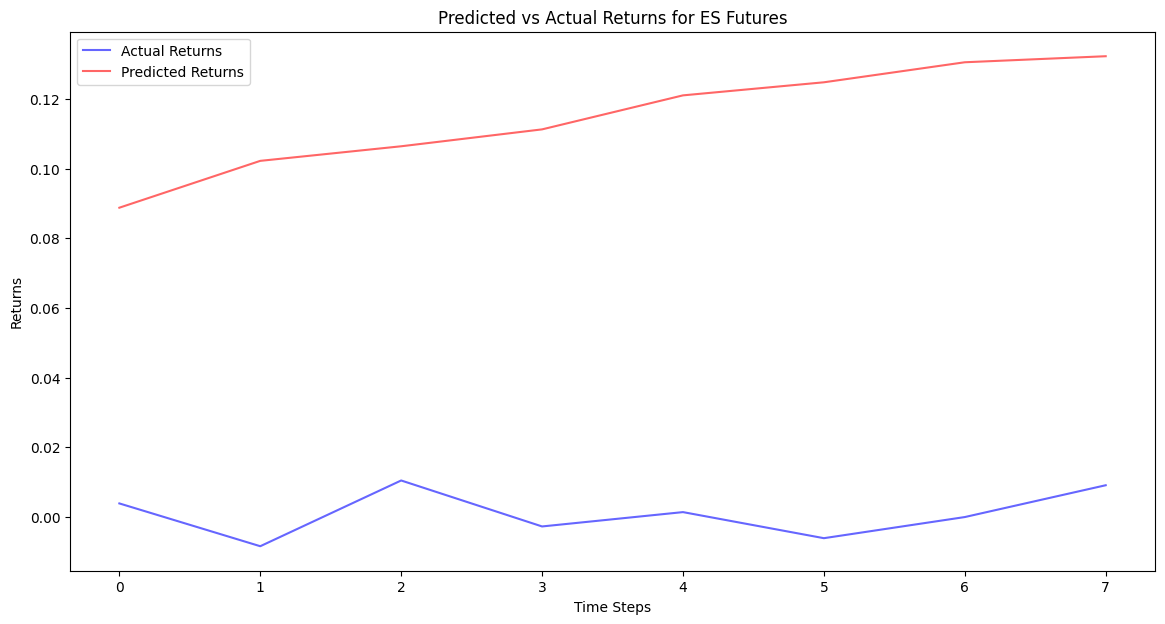

In [5]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# predictions on the test set
y_pred = model.predict(X_test)

# Plot of predicted vs actual returns
plt.figure(figsize=(14, 7))

# Plot actual returns (blue line)
plt.plot(y_test, label='Actual Returns', color='blue', alpha=0.6)

# Plot predicted returns (red line)
plt.plot(y_pred, label='Predicted Returns', color='red', alpha=0.6)

# Adding labels and title
plt.title("Predicted vs Actual Returns for ES Futures")
plt.xlabel("Time Steps")
plt.ylabel("Returns")

# Adding legend
plt.legend()

#  plot
plt.show()


In [6]:
import vectorbt as vbt

#  test close prices and signals for backtesting
close_prices = es_data['Close'].values[-len(X_test):]  # Corresponding close prices for the test set
entry_signal = y_pred > 0  # Go long if predicted return > 0
exit_signal = y_pred <= 0  # Exit if predicted return <= 0

# backtest
portfolio = vbt.Portfolio.from_signals(close_prices, entry_signal.flatten(), exit_signal.flatten())

# save performance metrics
portfolio_stats = portfolio.stats()
print(portfolio_stats)

# equity curve
portfolio.plot().show()


/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                           0.000000
End                             7.000000
Period                          8.000000
Start Value                   100.000000
End Value                      99.826505
Total Return [%]               -0.173495
Benchmark Return [%]           -0.173495
Max Gross Exposure [%]        100.000000
Total Fees Paid                 0.000000
Max Drawdown [%]                0.841975
Max Drawdown Duration           4.000000
Total Trades                    1.000000
Total Closed Trades             0.000000
Total Open Trades               1.000000
Open Trade PnL                 -0.173495
Win Rate [%]                         NaN
Best Trade [%]                       NaN
Worst Trade [%]                      NaN
Avg Winning Trade [%]                NaN
Avg Losing Trade [%]                 NaN
Avg Winning Trade Duration           NaN
Avg Losing Trade Duration            NaN
Profit Factor                        NaN
Expectancy                           NaN
dtype: float64


In [7]:
# Saving the trained model
model.save('es_transformer_model')

# Saving backtest results as HTML
portfolio.plot().write_html('backtest_results.html')

#files from Colab
from google.colab import files
files.download('es_transformer_model')
files.download('backtest_results.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>